In [ ]:
# get data
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/dataset/

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve
from matplotlib import pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import pickle
import seaborn as sns

# Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

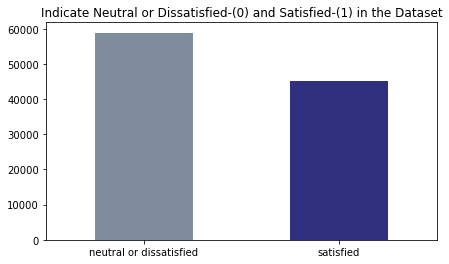

In [6]:
# Checking whether the dataset is balanced or imbalanced
fig = plt.figure(figsize = (7,4))
train.satisfaction.value_counts().plot(kind='bar', color= ['slategrey','midnightblue'], alpha = 0.9, rot=0)
plt.title('Indicate Neutral or Dissatisfied-(0) and Satisfied-(1) in the Dataset')
plt.show()

# Data Preprocessing

In [7]:
# Drop unnecessary columns
train = train.drop('Unnamed: 0', axis=1)
train = train.drop('id', axis=1)

test = test.drop('Unnamed: 0', axis=1)
test = test.drop('id', axis=1)

In [8]:
train.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [9]:
# Replace spaces in the column names with underscore
train.columns = [c.replace(' ', '_') for c in train.columns]
test.columns = [c.replace(' ', '_') for c in test.columns]

In [10]:
train.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [11]:
train['satisfaction'].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

In [12]:
# convert neutral or dissatisfied into 0 and satisfied into 1
train['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)
test['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)

In [13]:
train['satisfaction'].unique()

array([0, 1], dtype=int64)

In [14]:
# finding missing data
tot = train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([tot, percentage], axis=1, keys=['Total Number of Rows', 'Percentage'])

In [15]:
missing_data.head()

,Total Number of Rows,Percentage
Arrival_Delay_in_Minutes,310,0.002984
Gender,0,0.000000
Seat_comfort,0,0.000000
Departure_Delay_in_Minutes,0,0.000000
Cleanliness,0,0.000000


In [16]:
# filling missing values with the mean value
train['Arrival_Delay_in_Minutes'] = train['Arrival_Delay_in_Minutes'].fillna(train['Arrival_Delay_in_Minutes'].mean())

test['Arrival_Delay_in_Minutes'] = test['Arrival_Delay_in_Minutes'].fillna(test['Arrival_Delay_in_Minutes'].mean())

In [17]:
print(missing_data)

                                   Total Number of Rows  Percentage
Arrival_Delay_in_Minutes                            310    0.002984
Gender                                                0    0.000000
Seat_comfort                                          0    0.000000
Departure_Delay_in_Minutes                            0    0.000000
Cleanliness                                           0    0.000000
Inflight_service                                      0    0.000000
Checkin_service                                       0    0.000000
Baggage_handling                                      0    0.000000
Leg_room_service                                      0    0.000000
On-board_service                                      0    0.000000
Inflight_entertainment                                0    0.000000
Online_boarding                                       0    0.000000
Customer_Type                                         0    0.000000
Food_and_drink                                  

In [18]:
# filling missing values of categorical data
train.select_dtypes(include=['object']).columns

train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])
train['Customer_Type'] = train['Customer_Type'].fillna(train['Customer_Type'].mode()[0])
train['Type_of_Travel'] = train['Type_of_Travel'].fillna(train['Type_of_Travel'].mode()[0])
train['Class'] = train['Class'].fillna(train['Class'].mode()[0])

test['Gender'] = test['Gender'].fillna(test['Gender'].mode()[0])
test['Customer_Type'] = test['Customer_Type'].fillna(test['Customer_Type'].mode()[0])
test['Type_of_Travel'] = test['Type_of_Travel'].fillna(test['Type_of_Travel'].mode()[0])
test['Class'] = test['Class'].fillna(test['Class'].mode()[0])

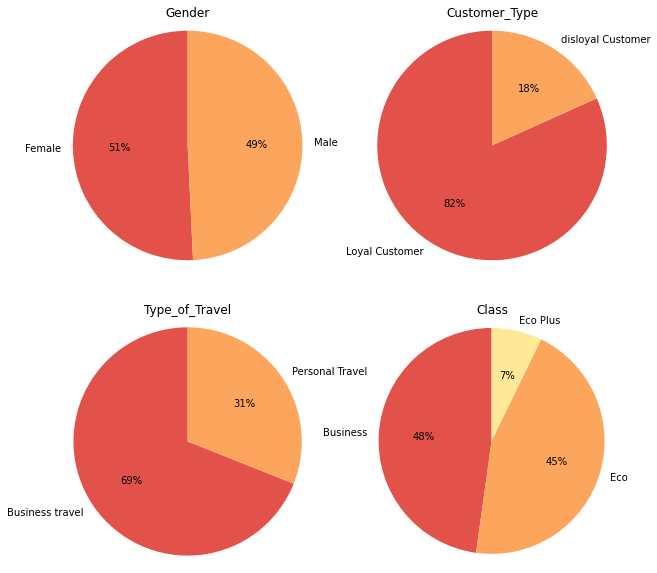

In [19]:
#display the insight of the data sample
figure = [0, 1, 3, 4]
count = train.iloc[:,figure]
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
for i, columns in enumerate(count):
    column_values = train[columns].value_counts()
    label = column_values.index
    total = column_values.values
    axes[i//2, i%2].pie(total, labels = label, colors = sns.color_palette("Spectral"), autopct = '%1.0f%%', startangle = 90)
    axes[i//2, i%2].axis('equal')
    axes[i//2, i%2].set_title(columns)
plt.show()

In [20]:
# encoding categorical variables
lencoders = {}
for c in train.select_dtypes(include=['object']).columns:
    lencoders[c] = LabelEncoder()
    train[c] = lencoders[c].fit_transform(train[c])

lencoders_t = {}
for c in test.select_dtypes(include=['object']).columns:
    lencoders_t[c] = LabelEncoder()
    test[c] = lencoders_t[c].fit_transform(test[c])

In [21]:
train['Gender'].unique()

array([1, 0])

In [22]:
train['Customer_Type'].unique()

array([0, 1])

In [23]:
train['Type_of_Travel'].unique()

array([1, 0])

In [24]:
train['Class'].unique()

array([2, 0, 1])

In [25]:
# finding outliers
Quantile1 = train.quantile(0.25)
Quantile3 = train.quantile(0.75)
IQR = Quantile3 - Quantile1

print(IQR)

Gender                                  1.0
Customer_Type                           0.0
Age                                    24.0
Type_of_Travel                          1.0
Class                                   1.0
Flight_Distance                      1329.0
Inflight_wifi_service                   2.0
Departure/Arrival_time_convenient       2.0
Ease_of_Online_booking                  2.0
Gate_location                           2.0
Food_and_drink                          2.0
Online_boarding                         2.0
Seat_comfort                            3.0
Inflight_entertainment                  2.0
On-board_service                        2.0
Leg_room_service                        2.0
Baggage_handling                        2.0
Checkin_service                         1.0
Inflight_service                        2.0
Cleanliness                             2.0
Departure_Delay_in_Minutes             12.0
Arrival_Delay_in_Minutes               13.0
satisfaction                    

In [26]:
train.shape

(103904, 23)

In [27]:
# removing outliers
train = train[~((train < (Quantile1 - 1.5 * IQR)) |(train > (Quantile3 + 1.5 * IQR))).any(axis=1)]

In [28]:
train.shape

(61197, 23)

# Find Feature Importance

In [29]:
# feature importance (permutation)
X = train.drop('satisfaction', axis=1)
y = train['satisfaction']
warnings.filterwarnings("ignore")
perm = PermutationImportance(rf(n_estimators=100, random_state=0).fit(X,y),random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.2723 ± 0.0039,Type_of_Travel
0.1278 ± 0.0026,Inflight_wifi_service
0.0435 ± 0.0011,Online_boarding
0.0424 ± 0.0013,Seat_comfort
0.0355 ± 0.0009,Checkin_service
0.0294 ± 0.0014,Inflight_service
0.0289 ± 0.0008,Baggage_handling
0.0246 ± 0.0006,Cleanliness
0.0177 ± 0.0007,On-board_service
0.0172 ± 0.0007,Class


# Build the Models

In [30]:
# Define the features and the target of Models
features = ['Type_of_Travel', 'Inflight_wifi_service','Online_boarding','Seat_comfort', 'Checkin_service']
target = ['satisfaction']

# Split into test and train
X_train = train[features]
y_train = train[target].to_numpy()
X_test = test[features]
y_test = test[target].to_numpy()

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [31]:
def calculate_time_taken(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train.ravel(), verbose=0)
    else:
        model.fit(X_train,y_train.ravel())
    time_taken = time.time()-t0
    print("Time taken = {}".format(time_taken))
    
    return time_taken

In [32]:
def classification_model(model, X_train, y_train, X_test, y_test):
    # train the model using the training set
    model.fit(X_train, y_train)
    # predictions
    y_pred = model.predict(X_test)
    # Model Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    #Plot the Confusion Matrix
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(model_dt, X_test, y_test,cmap=plt.cm.bone, normalize = 'all')
    plt.title('Confusion matrix of the Model',size = 16)
    plt.ylabel('Actual Class',size = 14)
    plt.xlabel('Predicted Class',size = 14)
    # Text summary of the precision, recall, F1 score
    print(classification_report(y_test,y_pred,digits=5))                   
    
    return model, accuracy

# Decision Tree

Accuracy: 0.8787342161995688
              precision    recall  f1-score   support

           0    0.92556   0.85240   0.88748     14573
           1    0.82867   0.91239   0.86852     11403

    accuracy                        0.87873     25976
   macro avg    0.87712   0.88239   0.87800     25976
weighted avg    0.88303   0.87873   0.87915     25976

Time taken = 0.02161884307861328


<Figure size 432x432 with 0 Axes>

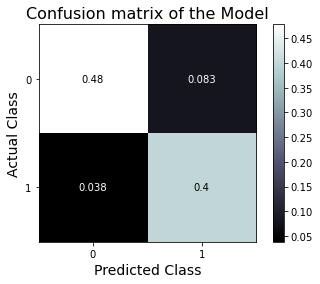

In [33]:
# Decision Tree Model
model_dt = DecisionTreeClassifier(criterion = "gini",random_state = 100)

# Accuracy, confusion matrix and text summary (precision, recall, F1 score) according to the function
model_dt, accuracy_dt = classification_model(model_dt, X_train, y_train, X_test, y_test)

# Time taken to execute the model
tt_dt = calculate_time_taken(model_dt, X_train, y_train, X_test, y_test)

# save model
pickle.dump(model_dt, open('model.pkl', 'wb'))

# Random Forest

Accuracy: 0.8783107483831228
              precision    recall  f1-score   support

           0    0.92595   0.85116   0.88698     14573
           1    0.82758   0.91301   0.86820     11403

    accuracy                        0.87831     25976
   macro avg    0.87677   0.88208   0.87759     25976
weighted avg    0.88277   0.87831   0.87874     25976

Time taken = 1.1899592876434326


<Figure size 432x432 with 0 Axes>

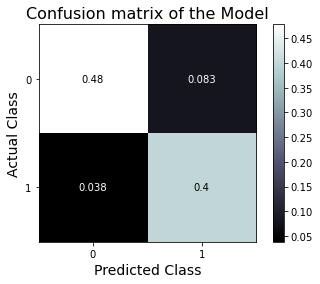

In [34]:
# Random Forest Model
model_rf = RandomForestClassifier()

# Accuracy, confusion matrix and text summary (precision, recall, F1 score) according to the function
model_rf, accuracy_rf = classification_model(model_rf, X_train, y_train, X_test, y_test)

# Time taken to execute the model
tt_rf = calculate_time_taken(model_rf, X_train, y_train, X_test, y_test)

# K Nearest Neighbour

Accuracy: 0.8691099476439791
              precision    recall  f1-score   support

           0    0.90786   0.85329   0.87973     14573
           1    0.82588   0.88933   0.85643     11403

    accuracy                        0.86911     25976
   macro avg    0.86687   0.87131   0.86808     25976
weighted avg    0.87187   0.86911   0.86950     25976

Time taken = 0.09199690818786621


<Figure size 432x432 with 0 Axes>

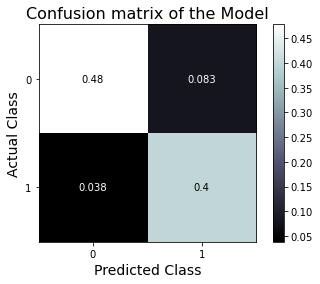

In [35]:
# K Nearest Neighbour Model
model_kn = KNeighborsClassifier(n_neighbors=10, algorithm= 'kd_tree', n_jobs=4)

# Accuracy, confusion matrix and text summary (precision, recall, F1 score) according to the function
model_kn, accuracy_kn = classification_model(model_kn, X_train, y_train, X_test, y_test)

# Time taken to execute the model
tt_kn = calculate_time_taken(model_kn, X_train, y_train, X_test, y_test)

# Model Comparison

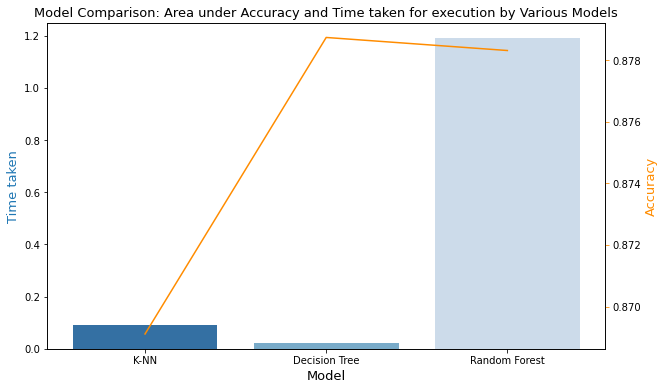

In [36]:
accuracy = [accuracy_kn, accuracy_dt, accuracy_rf]
tt = [tt_kn, tt_dt, tt_rf]

model_data = {'Model': ['K-NN','Decision Tree','Random Forest'],
              'Accuracy': accuracy,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Model Comparison: Area under Accuracy and Time taken for execution by Various Models', fontsize=13)
color = 'tab:blue'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='Blues_r')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'darkorange'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)